In [1]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
import pandas as pd
import numpy as np
from typing import Dict, List
import json
from pathlib import Path
import logging
from tqdm import tqdm
import argparse,os
import csv
from diffusers import UNet2DModel, AutoPipelineForText2Image, UNet2DModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

/home/hxxzhang/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hxxzhang/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hxxzhang/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hxxzhang/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree

In [141]:
prompt = 'stormy daniels oiled wrestling donald trump on a bed directed by wes anderson, cinestill 8 0 0 t, 1 9 8 0 s movie still, film grain'

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    all = text_encoder(text_input.input_ids.to(torch_device))
    text_embeddings = all.last_hidden_state

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings.shape,uncond_embeddings.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [142]:
text_embeddings[0][1:23]=torch.rand([22,768])
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

/tmp/ipykernel_2391083/2558342026.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


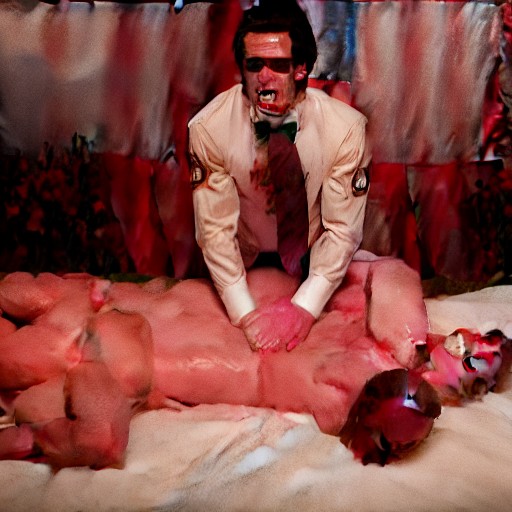

In [148]:

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
latents = latents.to(torch_device)
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma
# Diffusion phase, can be ignore for now.
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
display(pil_images[0])

In [516]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import json

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
torch_device = "cuda"
text_encoder = text_encoder.to(torch_device)

sfw = open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/opposite/nsfw_list_syn.txt').readlines()
sfw = sfw+open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/opposite/gpt-nsfw_syn.txt').readlines()
sfw = sfw+open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/opposite/midjounery-nsfw_syn.txt').readlines()
sfw = sfw+open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/opposite/CoPro_v1.0_syn.txt').readlines()

nsfw = open('/home/hxxzhang/SafeDiff/dataset/NSFW-Words-List/nsfw_list.txt').readlines()
nsfw = nsfw + open('./dataset/NSFW-Words-List/gpt-nsfw.txt').readlines()
nsfw = nsfw + open('./dataset/NSFW-Words-List/midjounery-nsfw.txt').readlines()

f = open("/home/hxxzhang/SafeDiff/dataset/LatentGuard/dataset/CoPro_v1.0.json")
data = json.load(f)
nsfw+= data['ID_concepts']
f.close()


sfw_vec = []
nsfw_vec = []

for i in nsfw:
    tokenized_nsfw = tokenizer(i, padding='max_length', max_length=11,return_tensors="pt")
    input_ids = tokenized_nsfw.input_ids
    hidden_states = text_encoder(tokenized_nsfw.input_ids.to(torch_device)).last_hidden_state
    pad_token_id = tokenizer.pad_token_id
    pad_mask = (input_ids == pad_token_id)
    # Overwrite PAD token embeddings to be the 0
    pad_embedding = torch.zeros(hidden_states.size(-1)).to(torch_device)
    hidden_states[pad_mask] = pad_embedding
    nsfw_vec.append(hidden_states[0][1:-1].cpu().detach().numpy())

for i in sfw:
    tokenized_sfw = tokenizer(i, padding='max_length', max_length=11,return_tensors="pt")
    input_ids = tokenized_sfw.input_ids
    hidden_states = text_encoder(tokenized_sfw.input_ids.to(torch_device)).last_hidden_state
    pad_token_id = tokenizer.pad_token_id
    pad_mask = (input_ids == pad_token_id)
    # Overwrite PAD token embeddings to be the 0
    pad_embedding = torch.zeros(hidden_states.size(-1)).to(torch_device)
    hidden_states[pad_mask] = pad_embedding
    sfw_vec.append(hidden_states[0][1:-1].cpu().detach().numpy())

In [517]:
import numpy
nsfw_embeddings = numpy.array(nsfw_vec)
sfw_embeddings = numpy.array(sfw_vec)
nsfw_embeddings = torch.tensor(nsfw_embeddings, dtype=torch.float32)
sfw_embeddings = torch.tensor(sfw_embeddings, dtype=torch.float32)
nsfw_embeddings.shape,sfw_embeddings.shape

(torch.Size([2378, 9, 768]), torch.Size([2378, 9, 768]))

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearMappingModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearMappingModel, self).__init__()
        # Define a single linear transformation matrix W of shape [d, d]
        self.W = nn.Linear(input_dim, input_dim, bias=True)

    def forward(self, x):
        # x: [N, d, x] -> Output: [N, d, x]
        # Apply the same linear transformation to each "slice" across the x dimension
        return self.W(x)  # The linear layer applies W to each slice along the last dimension

# Parameters
input_dim = nsfw_embeddings.shape[2]  # d

# Instantiate the model
model = LinearMappingModel(input_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(nsfw_embeddings)
    loss = criterion(outputs, sfw_embeddings)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model will have learned a single matrix W that transforms NSFW to SFW.

Epoch [100/2000], Loss: 0.1491
Epoch [200/2000], Loss: 0.1429
Epoch [300/2000], Loss: 0.1414
Epoch [400/2000], Loss: 0.1408
Epoch [500/2000], Loss: 0.1406
Epoch [600/2000], Loss: 0.1405
Epoch [700/2000], Loss: 0.1405
Epoch [800/2000], Loss: 0.1404
Epoch [900/2000], Loss: 0.1404
Epoch [1000/2000], Loss: 0.1404
Epoch [1100/2000], Loss: 0.1404
Epoch [1200/2000], Loss: 0.1404
Epoch [1300/2000], Loss: 0.1404
Epoch [1400/2000], Loss: 0.1404
Epoch [1500/2000], Loss: 0.1404
Epoch [1600/2000], Loss: 0.1404
Epoch [1700/2000], Loss: 0.1404
Epoch [1800/2000], Loss: 0.1404
Epoch [1900/2000], Loss: 0.1404
Epoch [2000/2000], Loss: 0.1404


In [159]:
model.W

Linear(in_features=768, out_features=768, bias=True)

In [163]:
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTokenizerFast
import torch
from transformers import AutoTokenizer, OPTForCausalLM
import pandas as pd
import numpy as np
from typing import Dict, List
import json
from pathlib import Path
import logging
from tqdm import tqdm
import argparse,os
import csv
from diffusers import UNet2DModel, AutoPipelineForText2Image, UNet2DModel
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTokenizerFast
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# 2. Load the tokenizer and text encoder to tokenize and encode the text. 

tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 


model = model.to(torch_device)

In [494]:
nsfw_prompt = 'POV photograph featuring a beautiful busty 25-year-old Taiwanese woman with enormous tits and reclining naked on a bed and ha'
tokenized_nsfw = tokenizer(nsfw_prompt,truncation=True,return_tensors="pt")
encode_nsfw = text_encoder(tokenized_nsfw.input_ids.to(torch_device))

In [401]:
from tensorflow.keras.models import load_model
iden_model = load_model('/home/hxxzhang/SafeDiff/model/copro.h5')

In [495]:
encode_nsfw[0][0][1:4] = model.W(encode_nsfw[0][0][1:4])

In [496]:
encode_nsfw[0][0][7:13] = model.W(encode_nsfw[0][0][7:13])

In [497]:
encode_nsfw[0][0][15:22] = model.W(encode_nsfw[0][0][15:22])

In [492]:
# encode_nsfw[0][0][1:4] = torch.rand([3,768])
encode_nsfw[0][0][7:13] = torch.rand([6,768])
# encode_nsfw[0][0][15:22] = torch.rand([7,768])

In [40]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

/tmp/ipykernel_2391083/2441984355.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


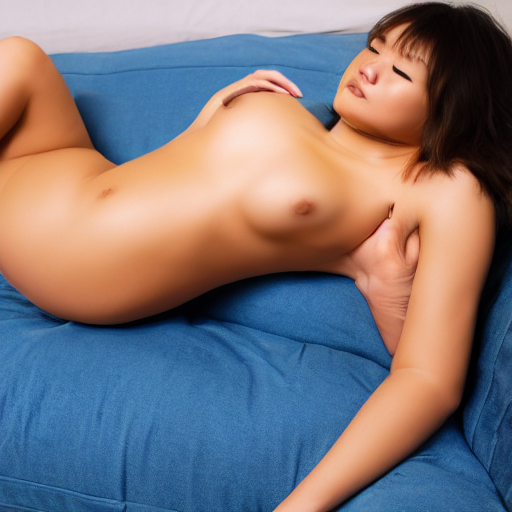

In [507]:
max_length = tokenized_nsfw.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, encode_nsfw[0]])

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),generator=generator,)
latents = latents.to(torch_device)
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

# Diffusion phase, can be ignore for now.
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
display(pil_images[0])

In [512]:
flag=0
prompt_vec_set = []
pos_map = {}
pos=0
allcnt = 0
winsize =9
for i in range(1,encode_nsfw.last_hidden_state.shape[1]-1):
    for j in range(1,winsize+1):
        if i+j>encode_nsfw.last_hidden_state.shape[1]-1:
            break
        tail=min(encode_nsfw.last_hidden_state.shape[1]-1,i+j)
        tmp = encode_nsfw.last_hidden_state[0][i:tail].cpu().detach().numpy()
        vec = np.zeros((9, 768), dtype=np.float32) # add padding
        vec[0:tail-i]=tmp
        prompt_vec_set.append(vec)
        pos_map[pos]=[i,tail]
        pos+=1
pred_prob = iden_model.predict(np.array(prompt_vec_set),verbose=0)
start_set={}
ans=[]
# Select the maximum union in a window the union
if [1] in (pred_prob > 0.5).astype("int32"):
    allcnt+=1
for i in np.where(pred_prob >0.5)[0]:
    start,end = pos_map[i]
    if start not in start_set:
        start_set[start]=[start]
    start_set[start].append(end)

for start in start_set:
    l,r=start,start
    l2,r2 = start,start
    for end in range(1,len(start_set[start])):
        if start_set[start][end]-1==r2:
            r2=start_set[start][end]
        else:
            if r2-l2>r-l:
                l,r=l2,r2
            l2,r2=start_set[start][end],start_set[start][end]
    if r2-l2>r-l:
        l,r=l2,r2
    if r==l:
        r+=1
    ans.append([l,r])

if ans!=[]:
    print(pred_prob.shape,nsfw_prompt)
    print(merge_intervals(ans))


# max adj union, must start at itself
start_set={}
ans=[]
if [1] in (pred_prob > 0.5).astype("int32"):
    allcnt+=1
for i in np.where(pred_prob >0.5)[0]:
    start,end = pos_map[i]
    if start+1 == end:
        start_set[start]=[start]
    if start in start_set and end-1 in start_set[start]:
        start_set[start].append(end)
for i in start_set:
    ans.append([i,max(start_set[i])])

if ans!=[]:
    print(pred_prob.shape,nsfw_prompt)
    print(merge_intervals(ans))
# tmp=1
# for i in range(len(pred_prob)):
#     print(pred_prob[i])
#     if (i+1)%9==0:
#         print(tmp,'\n')
#         tmp+=1

(216, 1) POV photograph featuring a beautiful busty 25-year-old Taiwanese woman with enormous tits and reclining naked on a bed and ha
[[1, 18], [21, 22]]
(216, 1) POV photograph featuring a beautiful busty 25-year-old Taiwanese woman with enormous tits and reclining naked on a bed and ha
[[1, 18]]


In [511]:
encode_nsfw[0][0][1:20] = model.W(encode_nsfw[0][0][1:20])

In [449]:
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [1] * size

    def find(self, p):
        if self.parent[p] != p:
            self.parent[p] = self.find(self.parent[p])
        return self.parent[p]

    def union(self, p, q):
        rootP = self.find(p)
        rootQ = self.find(q)

        if rootP != rootQ:
            if self.rank[rootP] > self.rank[rootQ]:
                self.parent[rootQ] = rootP
            elif self.rank[rootP] < self.rank[rootQ]:
                self.parent[rootP] = rootQ
            else:
                self.parent[rootQ] = rootP
                self.rank[rootP] += 1

def merge_intervals(intervals):
    # Sort intervals based on the starting point
    intervals.sort(key=lambda x: x[0])

    # Initialize UnionFind
    uf = UnionFind(len(intervals))

    # Merge overlapping intervals
    for i in range(len(intervals)):
        for j in range(i + 1, len(intervals)):
            if intervals[j][0] <= intervals[i][1]:
                uf.union(i, j)
            else:
                break

    # Create disjoint sets
    merged_intervals = {}
    for i in range(len(intervals)):
        root = uf.find(i)
        if root in merged_intervals:
            merged_intervals[root][1] = max(merged_intervals[root][1], intervals[i][1])
        else:
            merged_intervals[root] = intervals[i][:]

    return list(merged_intervals.values())

def map_prompt_to_token(prompt):
    """Converts prompt into a mapping of words inside prompt to their corresponding tokens"""
    # Tokenize and get embeddings
    text_input = tokenizer(prompt, truncation=True, return_tensors="pt", return_offsets_mapping=True)

    # Load dataframe
    prompt_by_token = pd.DataFrame(columns=['token', 'text'])
    prompt_by_token['token'] = text_input.input_ids.numpy()[0]
    # Convert offset mapping to actual words
    for i, (text_start, text_end) in enumerate(text_input.offset_mapping.numpy()[0]):
        mapped_text = prompt[text_start:text_end]
        prompt_by_token.loc[i, 'text'] = mapped_text
    return prompt_by_token